In [137]:
# Program setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from itertools import cycle
from statistics import mean
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.cluster import KMeans
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import make_scorer, accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, mean_absolute_error, precision_recall_fscore_support, recall_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

df = pd.read_csv("data/Dry_Bean_Dataset.csv")
seed = 14
np.random.seed(seed)

In [138]:
# Inspect data
print(df.info())

print('\n', df.shape)
df.head()

# No 'object' type features
# Values will need scaling
# Target variable is called 'Class'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [139]:
# Column names need tweaking
df = df.rename(columns={
    'MajorAxisLength': 'major_axis_length',
    'MinorAxisLength': 'minor_axis_length',
    'AspectRation': 'aspect_ratio', # This one is misspelt
    'ConvexArea': 'convex_area',
    'EquivDiameter': 'equivalent_diameter',
    'ShapeFactor1': 'shape_factor_1',
    'ShapeFactor2': 'shape_factor_2',
    'ShapeFactor3': 'shape_factor_3',
    'ShapeFactor4': 'shape_factor_4'
})

df.columns = df.columns.str.lower()
print(df.columns)

Index(['area', 'perimeter', 'major_axis_length', 'minor_axis_length',
       'aspect_ratio', 'eccentricity', 'convex_area', 'equivalent_diameter',
       'extent', 'solidity', 'roundness', 'compactness', 'shape_factor_1',
       'shape_factor_2', 'shape_factor_3', 'shape_factor_4', 'class'],
      dtype='object')


In [140]:
# Set numeric/categorical features & target
feature_names = list(df.columns)
target_name = feature_names.pop()

cat_feature_names = [col for col in feature_names if df[col].dtype == 'object']
print("The categorical features are: (There are no categorical features)\n", cat_feature_names)

num_feature_names = [col for col in feature_names if df[col].dtype == 'int64' or df[col].dtype == 'float64']
print("\nThe numeric features are: (All of the features are numeric)\n", num_feature_names)

print(f"\nThe target variable is:\n{target_name}")

The categorical features are: (There are no categorical features)
 []

The numeric features are: (All of the features are numeric)
 ['area', 'perimeter', 'major_axis_length', 'minor_axis_length', 'aspect_ratio', 'eccentricity', 'convex_area', 'equivalent_diameter', 'extent', 'solidity', 'roundness', 'compactness', 'shape_factor_1', 'shape_factor_2', 'shape_factor_3', 'shape_factor_4']

The target variable is:
class


In [141]:
# Check values for dtype 'object' columns; the only one is the target, 'Class', which I will change using .title()
unique_classes = df['class'].unique()
print(unique_classes)

for value in unique_classes:
    df['class'] = df['class'].replace(value, value.title())

# Check that classes have changed correctly
unique_classes = df['class'].unique()
print(unique_classes)

['SEKER' 'BARBUNYA' 'BOMBAY' 'CALI' 'HOROZ' 'SIRA' 'DERMASON']
['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']


In [142]:
# Check for missing values & duplicates. No missing values; 68 duplicates.
missing_values_count = df.isnull().sum()
print(missing_values_count)

duplicate_count = df.duplicated().sum()
print(f"\nThere are {duplicate_count} duplicates")

# Removing duplicates
print(f"Original DataFrame had {df.shape[0]} rows")
df = df.drop_duplicates()
print(f"After dropping duplicates, DataFrame has {df.shape[0]} rows")

area                   0
perimeter              0
major_axis_length      0
minor_axis_length      0
aspect_ratio           0
eccentricity           0
convex_area            0
equivalent_diameter    0
extent                 0
solidity               0
roundness              0
compactness            0
shape_factor_1         0
shape_factor_2         0
shape_factor_3         0
shape_factor_4         0
class                  0
dtype: int64

There are 68 duplicates
Original DataFrame had 13611 rows
After dropping duplicates, DataFrame has 13543 rows


In [143]:
# Summary statistics
target_stats = df[target_name].describe()
print(target_stats)

feature_num_stats = df[feature_names].describe()
feature_num_stats

# df[cat_feature_names].describe(include='object') # Not included, as there are not 'object' dtype features

count        13543
unique           7
top       Dermason
freq          3546
Name: class, dtype: object


,area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equivalent_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4
count,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000
mean,53048.460385,854.993406,319.895602,202.365321,1.581075,0.750315,53767.986709,253.034094,0.749829,0.987152,0.873671,0.800352,0.006561,0.001719,0.644341,0.995078
std,29392.438324,214.722684,85.809260,45.051632,0.245245,0.091858,29844.248525,59.307709,0.048939,0.004650,0.059393,0.061464,0.001130,0.000595,0.098653,0.004347
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36282.500000,703.230000,253.086806,175.886357,1.430662,0.715144,36673.000000,214.933277,0.718735,0.985678,0.833410,0.763228,0.005893,0.001158,0.582517,0.993720
50%,44580.000000,793.896000,296.404589,192.491117,1.549860,0.763997,45122.000000,238.245711,0.759903,0.988288,0.883490,0.801514,0.006643,0.001700,0.642424,0.996393
75%,61382.000000,977.146500,376.312489,217.245403,1.703916,0.809671,62360.000000,279.560351,0.786849,0.990019,0.917031,0.834470,0.007270,0.002173,0.696341,0.997891
max,254616.000000,1985.370000,738.860154,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


class
Dermason    3546
Sira        2636
Seker       2027
Horoz       1860
Cali        1630
Barbunya    1322
Bombay       522
Name: count, dtype: int64


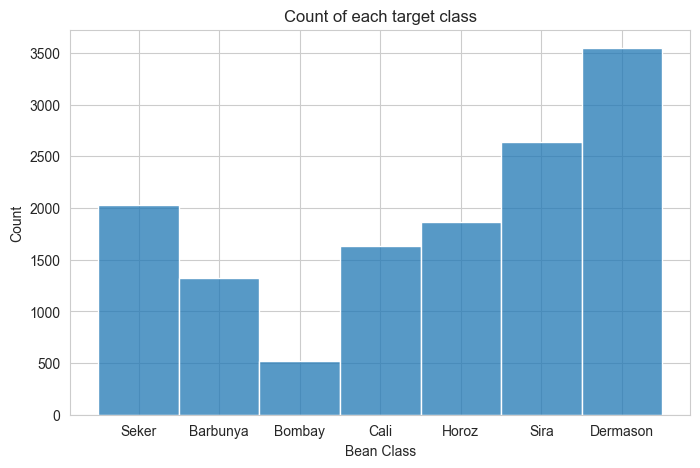

In [144]:
# Visualise distribution of target
sns.set_style('whitegrid')

plt.figure(figsize=(8,5))
plt.title('Count of each target class')
plt.xlabel('Bean Class')
plt.ylabel('Count')
plt.xticks(rotation=0, fontsize=10)
sns.histplot(df[target_name])

class_counts = (df[target_name].value_counts())
print(class_counts)

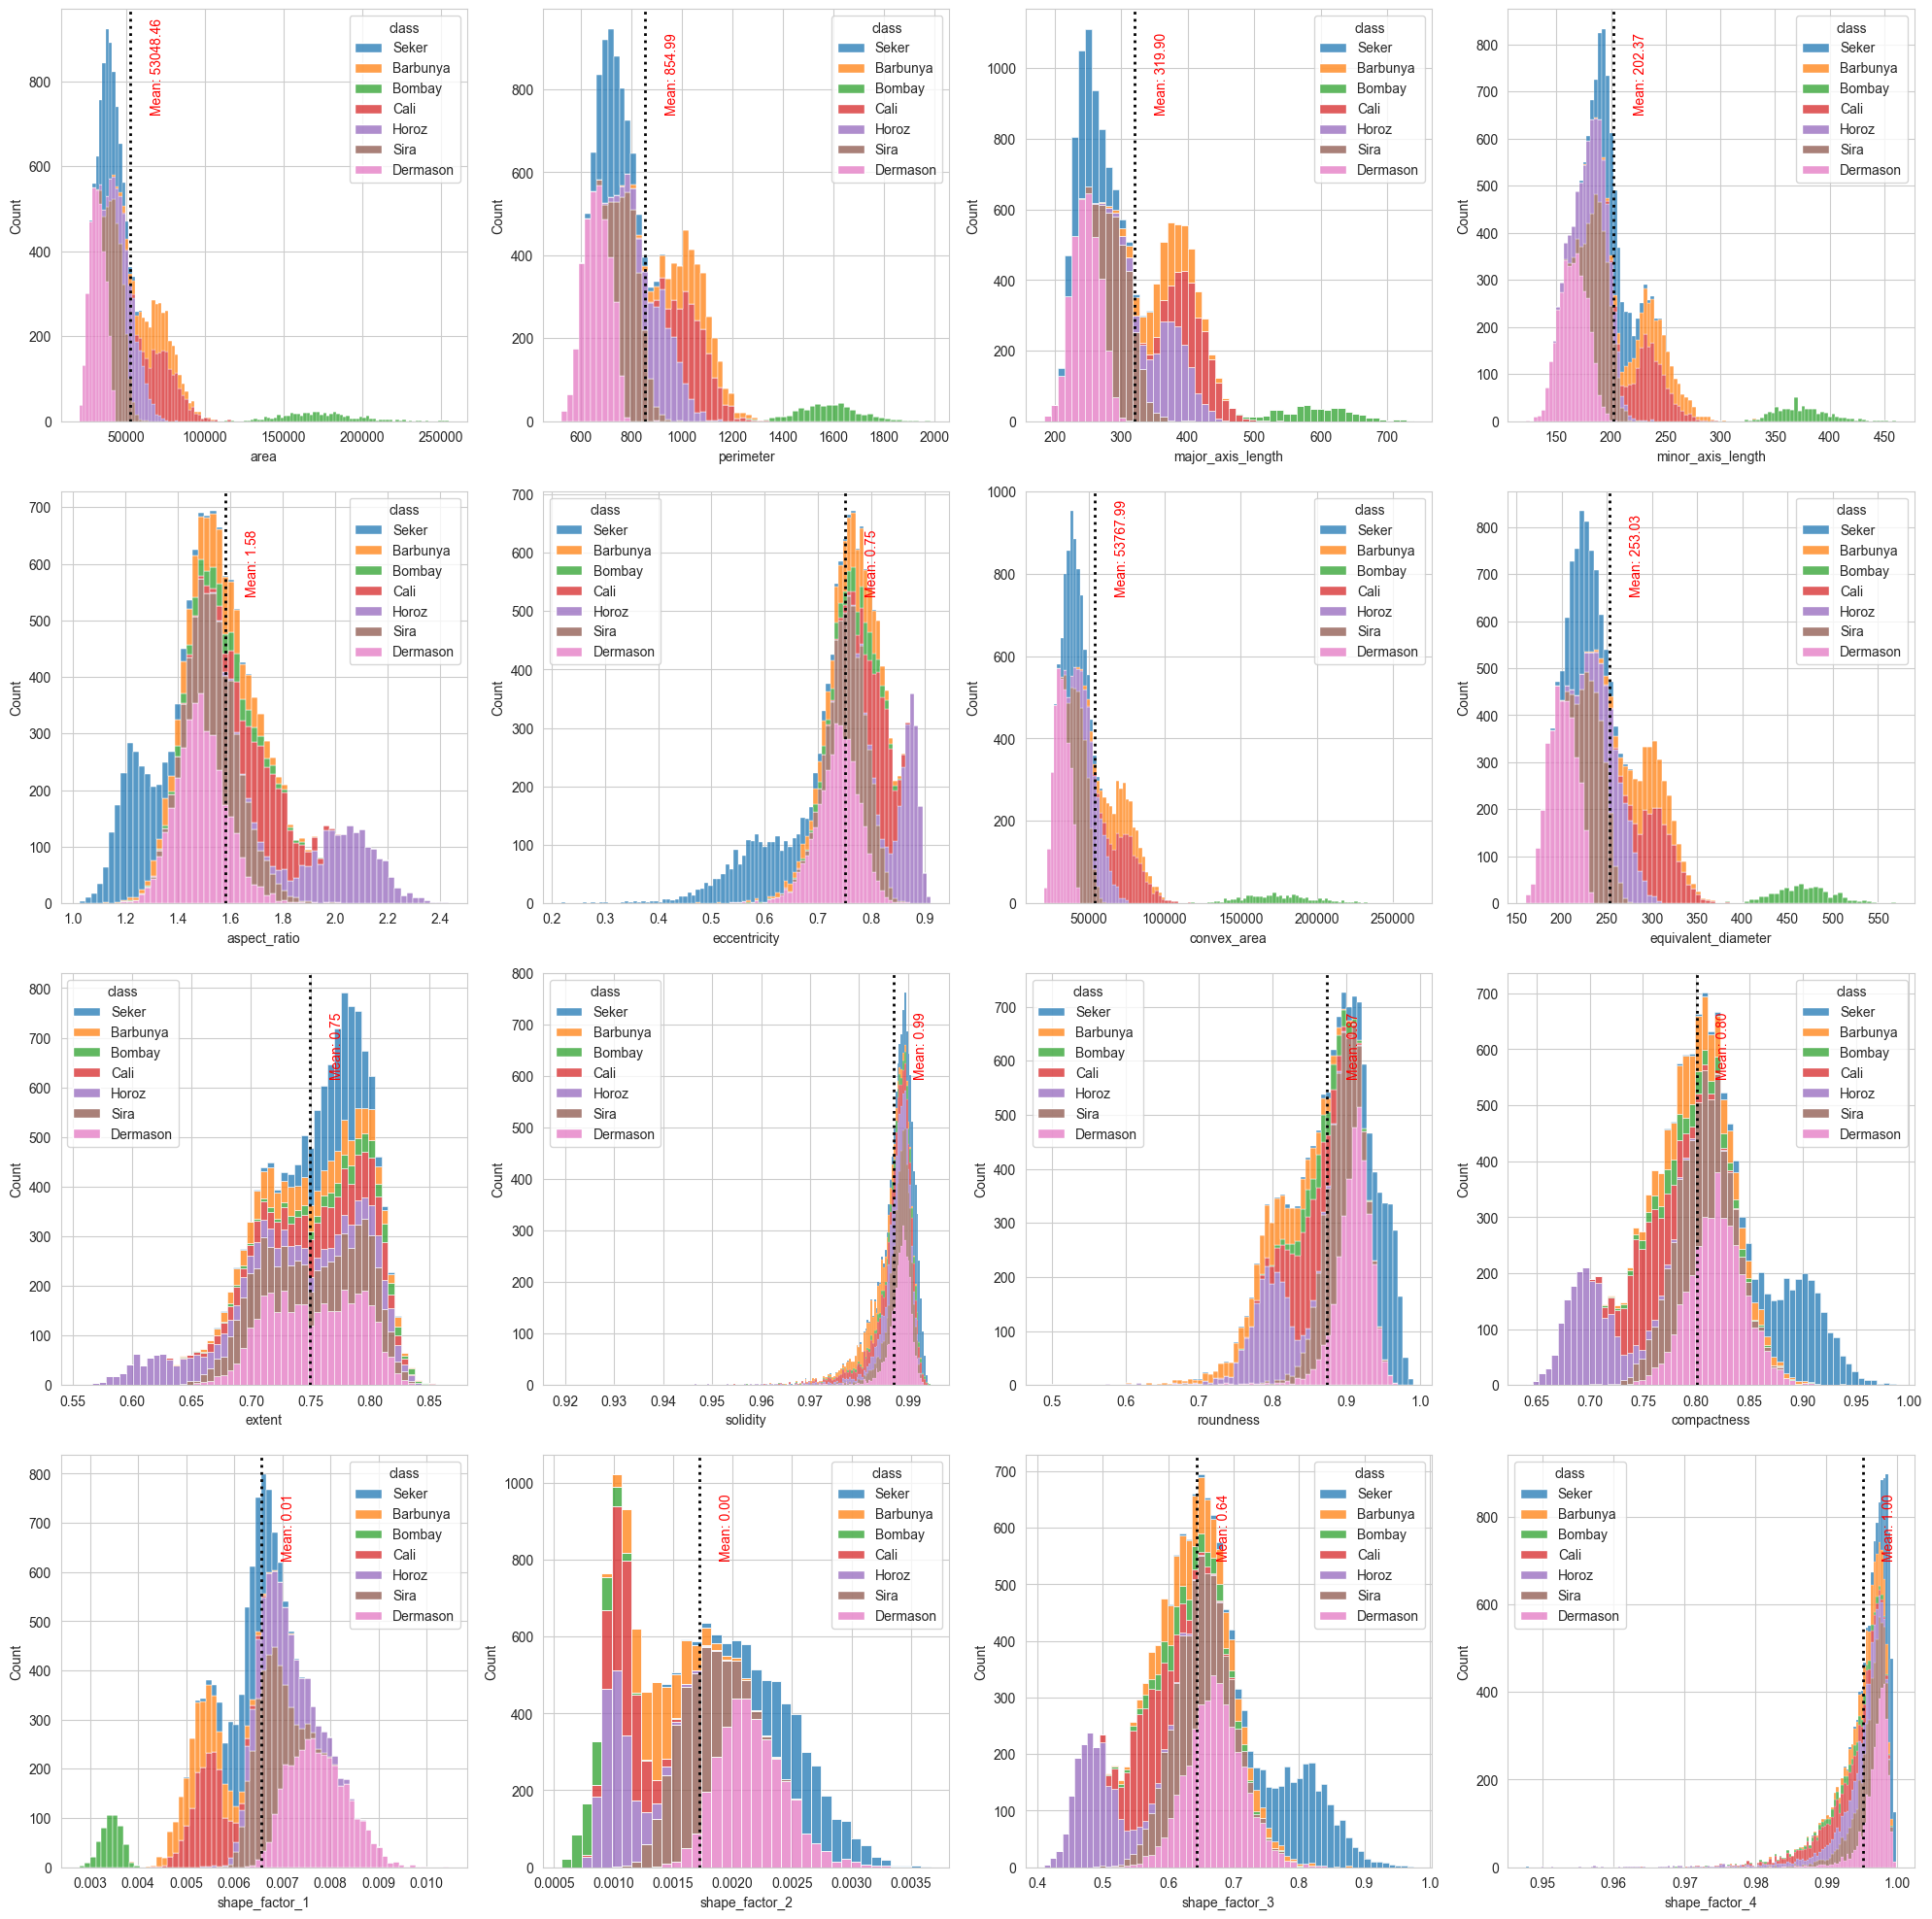

In [145]:
# Visualise distributions of features
fig, ax = plt.subplots(4,4, figsize=(20,20))

for feature, subplot in zip(feature_names, ax.flatten()):
    sns.histplot(data=df, x=feature, hue='class', ax=subplot, multiple='stack')
    subplot.axvline(x=df[feature].mean(), color='black', label='Mean', linestyle='dotted', linewidth=2)
    subplot.text(x=df[feature].mean()+ 0.05 * (subplot.get_xlim()[1] - subplot.get_xlim()[0]),
                  y=subplot.get_ylim()[1]*0.75, s=f"Mean: {df[feature].mean():.2f}", color='r', fontsize=10, rotation=90)
plt.tight_layout()

# Bombay is distinguishable on most features
# Seker distinguishable by eccentricity, compactness, & shape factor 3
# Horoz distinguishable by eccentricity, compactness, & shape factor 3

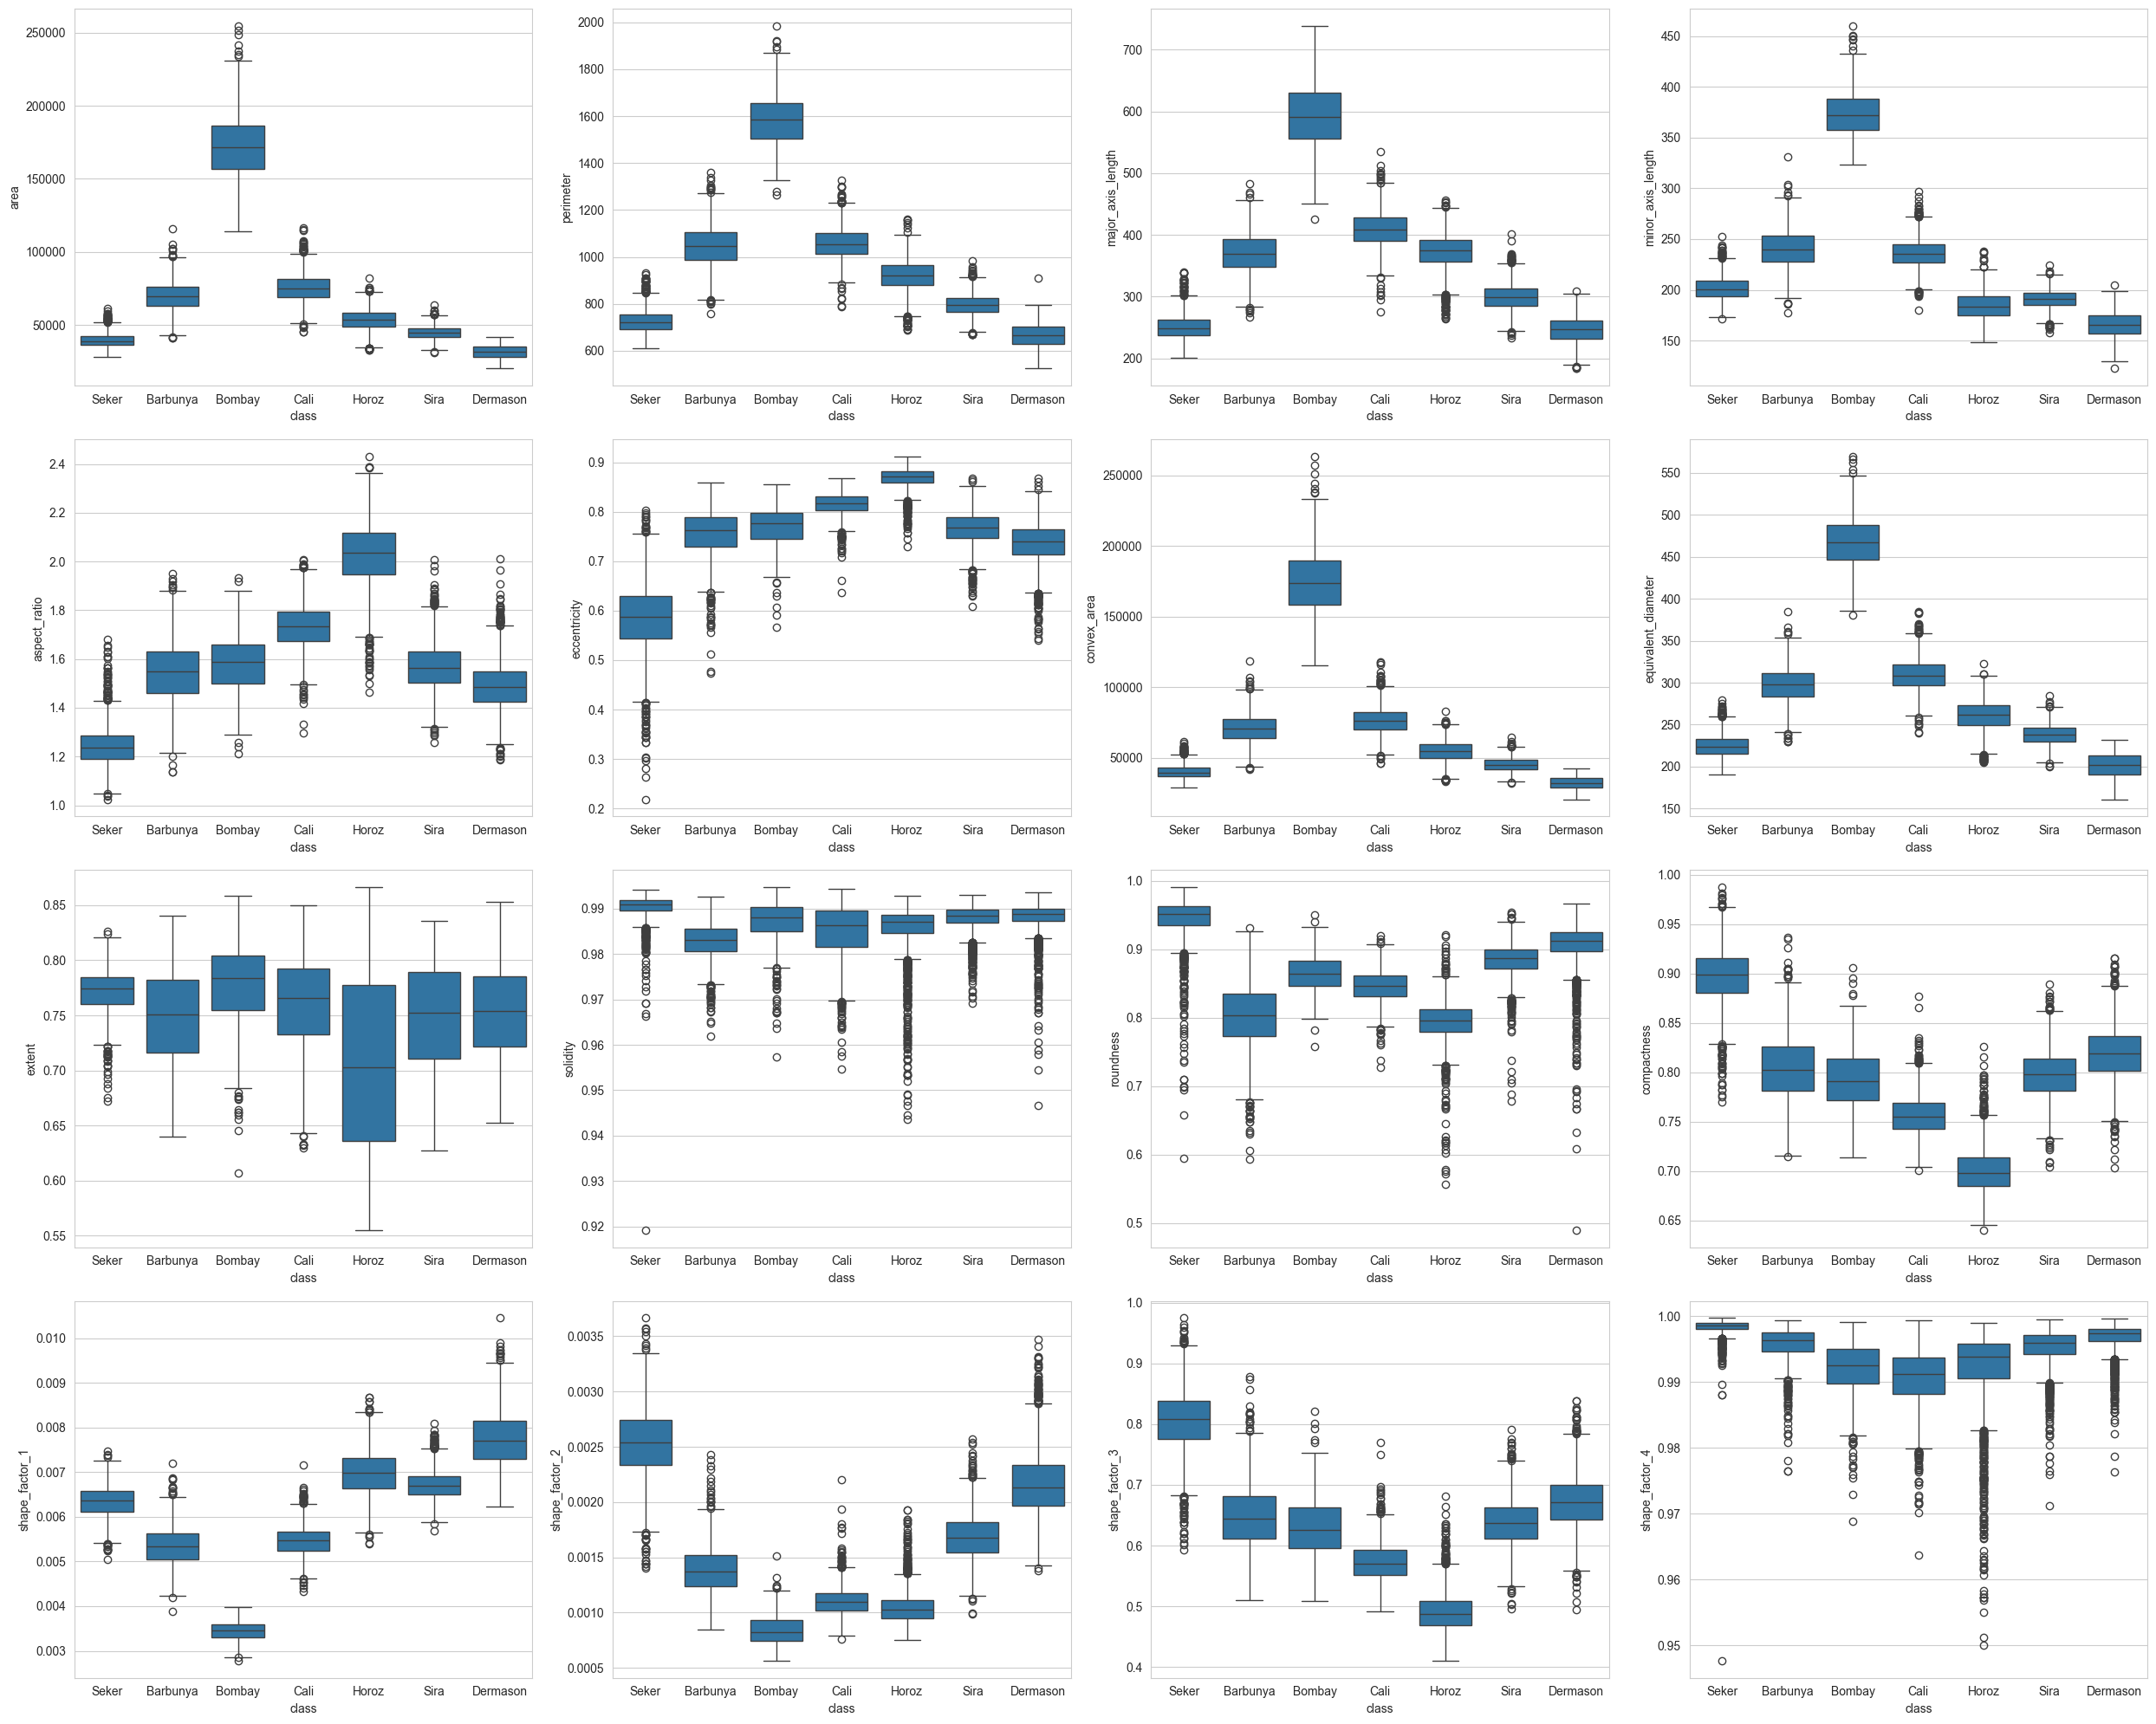

In [146]:
# Check for outliers
fig, ax = plt.subplots(4,4, figsize=(25,20))

for variable, subplot in zip(feature_names, ax.flatten()):
    sns.boxplot(x='class', y=variable, data=df, ax=subplot)
plt.tight_layout()

In [147]:
# Removing outliers
der_rou_filt = (df['roundness'] < 0.5) & (df['class'] == 'Dermason')
sek_sol_filt = (df['solidity'] < 0.93) & (df['class'] == 'Seker')
sek_sf4_filt = (df['shape_factor_4'] < 0.95) & (df['class'] == 'Seker')

df = df.loc[~der_rou_filt & ~sek_sol_filt & ~sek_sf4_filt]

# Reset class_counts
class_counts = df['class'].value_counts()

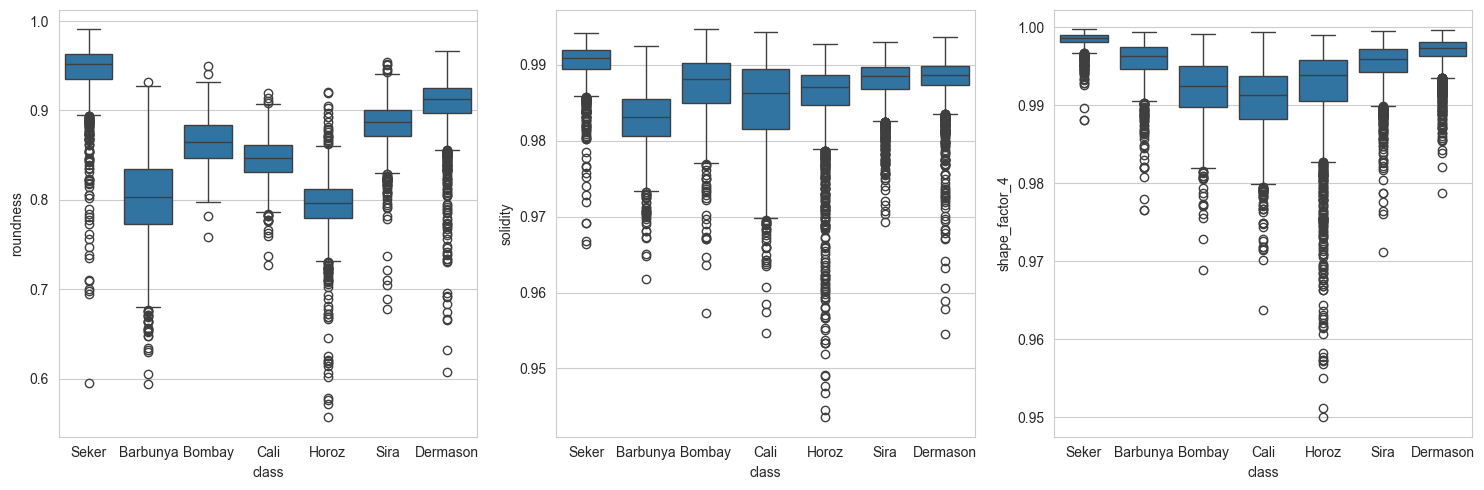

In [148]:
# View distributions with outliers have been removed
fig, ax = plt.subplots(1,3, figsize=(15,5))

for variable, subplot in zip(['roundness', 'solidity', 'shape_factor_4'], ax.flatten()):
        sns.boxplot(x='class', y=variable, data=df, ax=subplot)
plt.tight_layout()

<Axes: title={'center': 'Correlation Matrix'}>

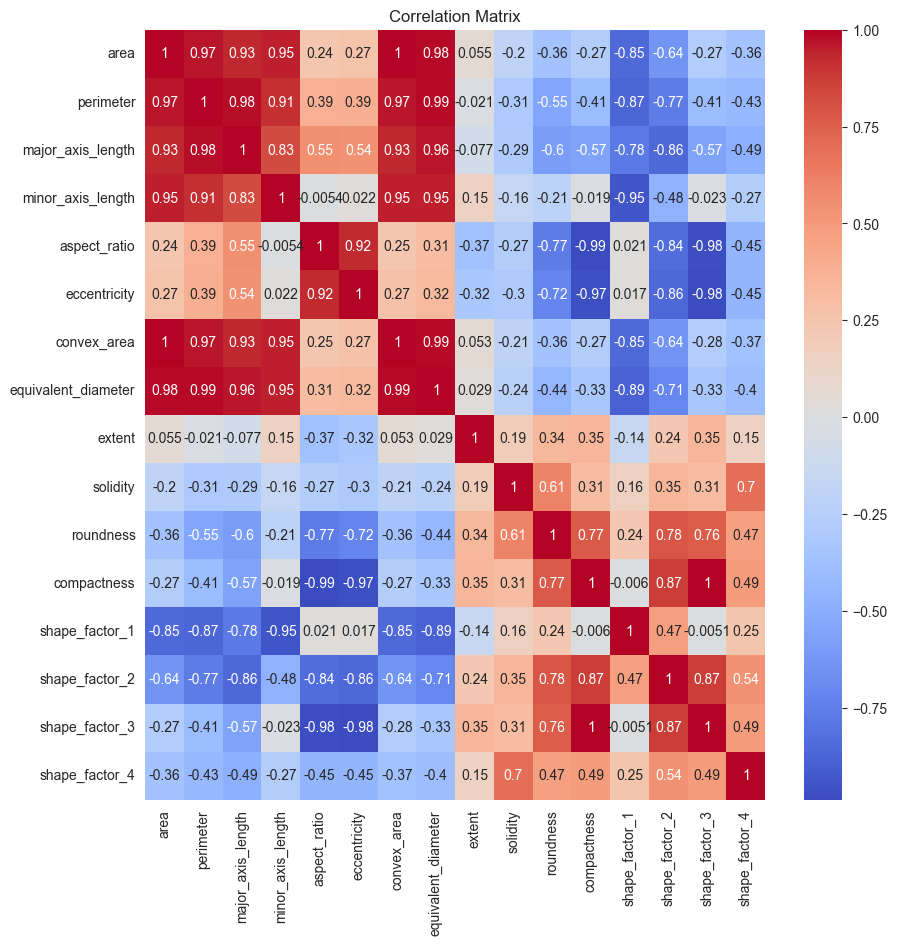

In [149]:
# Pearson's Correlation Matrix
plt.figure(figsize=(10,10))
plt.title("Correlation Matrix")
sns.heatmap(df[feature_names].corr('pearson'), cmap='coolwarm', annot=True)

In [150]:
# Label encoding target column
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])
df['class'] = df['class'].astype('category')

unique_labels = list(df['class'].unique())
print("The labels are: ", unique_labels)
print("The classes are: ", unique_classes)

label_dict = {}
for i, classes in enumerate(unique_classes):
    label_dict[unique_labels[i]] = classes

sorted_label_dict = {}
for i in range(len(unique_labels)):
    sorted_label_dict[i] = label_dict[i]
print("\nLabel Dictionary: ", sorted_label_dict)

# Compare the label counts to the class counts to check that the dictionary keys & values are assigned correctly
label_counts = df['class'].value_counts()
print(label_counts)
print(class_counts)


The labels are:  [5, 0, 1, 2, 4, 6, 3]
The classes are:  ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']

Label Dictionary:  {0: 'Barbunya', 1: 'Bombay', 2: 'Cali', 3: 'Dermason', 4: 'Horoz', 5: 'Seker', 6: 'Sira'}
class
3    3545
6    2636
5    2026
4    1860
2    1630
0    1322
1     522
Name: count, dtype: int64
class
Dermason    3545
Sira        2636
Seker       2026
Horoz       1860
Cali        1630
Barbunya    1322
Bombay       522
Name: count, dtype: int64


In [151]:
# Data preprocessing - splitting data
X = df.copy()
y = X.pop('class')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=seed)


# One-hot encode the target variable
one_hot_y_train = pd.DataFrame(to_categorical(y_train))
one_hot_y_valid = pd.DataFrame(to_categorical(y_valid))

# Testing dummy alternative
dummy_y_train = pd.get_dummies(y_train)
dummy_y_valid = pd.get_dummies(y_valid)

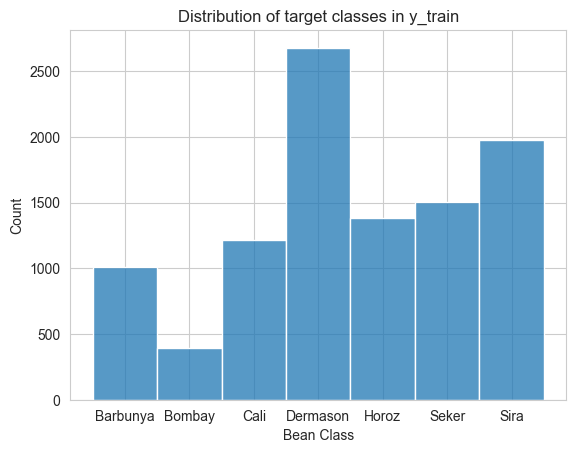

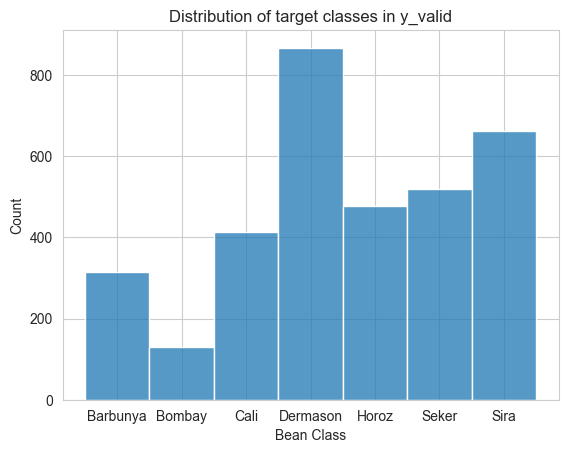

In [152]:
# Check that the target variable distributions in the y_train and y_valid sets are similar
def plot_target(data, name):
    plt.figure()
    sns.histplot(data=data)
    plt.title(f'Distribution of target classes in {name}')
    plt.xlabel('Bean Class')
    plt.ylabel('Count')
    plt.xticks(np.arange(7), list(sorted_label_dict.values()))
    plt.show()

plot_target(y_train, 'y_train')
plot_target(y_valid, 'y_valid')

In [153]:
# Define preprocessor for scaling - no need for imputing nor one-hot encoding of features
preprocessor = make_column_transformer(
    (StandardScaler(),
    make_column_selector(dtype_include=np.number))
    )

X_train = pd.DataFrame(preprocessor.fit_transform(X_train), index=X_train.index)
X_train.columns = feature_names

X_valid = pd.DataFrame(preprocessor.transform(X_valid), index=X_valid.index)
X_valid.columns = feature_names

# Check that the training set has scaled correctly
X_train.head()

,area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equivalent_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4
10778,-0.859785,-1.111876,-1.127452,-0.956273,-0.737236,-0.548934,-0.858594,-1.095004,0.374526,-0.021890,0.782206,0.695674,1.298533,1.316964,0.674156,0.052989
5024,0.912288,1.027463,1.220013,0.867284,0.726044,0.788990,0.912111,1.109895,1.498998,-0.242081,-0.112044,-0.805152,-1.100038,-1.137062,-0.816578,-0.755248
1645,-0.310001,-0.399190,-0.547889,0.072118,-1.036457,-1.014643,-0.307749,-0.278158,0.164923,-0.360385,1.006546,1.083945,-0.311454,0.746548,1.087896,0.512295
745,-0.517636,-0.709519,-0.906487,-0.067083,-1.496483,-1.998512,-0.523669,-0.565382,0.574724,1.062571,1.517630,1.733781,-0.145510,1.595560,1.806184,0.787830
1899,-0.174568,-0.298805,-0.552090,0.490707,-1.497621,-2.001514,-0.184223,-0.101484,0.216226,1.210991,1.509250,1.729246,-0.774075,1.091902,1.801059,0.590462


In [154]:
# Check that the validation set has scaled correctly
X_valid.head()

,area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equivalent_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4
3241,1.059346,1.273967,0.892754,1.537574,-0.493560,-0.236816,1.065196,1.253405,-0.092226,-0.709450,-0.734790,0.411092,-1.636278,-0.620920,0.378238,0.025865
11465,-0.766880,-0.934956,-0.921180,-0.904414,-0.372608,-0.099615,-0.765967,-0.942825,0.386479,-0.009201,0.382698,0.296169,1.176237,0.783774,0.260494,0.711359
12268,-0.660989,-0.823586,-0.791549,-0.706922,-0.423266,-0.155790,-0.663062,-0.777470,-0.202362,0.508694,0.769949,0.341345,0.822905,0.645211,0.306658,0.336419
5319,1.155447,1.333860,1.575175,0.957206,1.114522,1.000838,1.143663,1.345203,0.081468,0.583332,-0.589387,-1.125011,-1.176215,-1.338917,-1.111991,-0.823033
5687,-0.311564,-0.074009,0.317379,-0.890991,2.279848,1.458550,-0.312536,-0.280244,-0.093037,0.105951,-1.524681,-1.943960,1.190786,-1.126466,-1.832648,-0.645106


In [155]:
# Define function for learning curves to check overfitting

def get_learning_curves(model):
    # Define the range of training sizes (percentages of the dataset)
    train_sizes = np.linspace(0.1, 1.0, 10)

    # Calculate learning curves
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='accuracy'
    )

    # Calculate mean and standard deviation of scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes_abs, train_scores_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes_abs, val_scores_mean, label='Validation score', color='orange')
    plt.fill_between(train_sizes_abs, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color='orange')
    plt.xlabel('Number of training examples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [156]:
# Define function for evaluation metrics

def eval_model(model):
    # mae = round(mean_absolute_error(y_valid, y_preds), 3) keras.src.engine.sequential.Sequential
    if isinstance(model, keras.Sequential):
        neural_y_preds = pd.DataFrame(neural_model.predict(X_valid))
        neural_y_class_preds = np.argmax(neural_y_preds, axis=1)
        y_preds = neural_y_class_preds
    else:    
        y_preds = model.predict(X_valid)
    
    accuracy = round(accuracy_score(y_valid, y_preds), 3)
    prfs_average = precision_recall_fscore_support(y_valid, y_preds, average='macro')
    precision_ind, recall_ind, f_score_ind, support_ind = precision_recall_fscore_support(y_valid, y_preds, average=None)

    print(f"Accuracy: {accuracy}\nAverage Precision: {round(prfs_average[0], 3)}\nAverage Recall: {round(prfs_average[1], 3)}\nAverage F1-Score: {round(prfs_average[2], 3)}")
    print(f"\nClass order: {unique_classes}")
    print(f"Support for each class: {support_ind}")
    print(f"Per-class Precision: {np.round(precision_ind, 3)}\nPer-class Recall:    {np.round(recall_ind, 3)}\nPer-class F1-score:  {np.round(f_score_ind, 3)}")

    c_mat = confusion_matrix(y_valid, y_preds)
    display = ConfusionMatrixDisplay(c_mat, display_labels=list(unique_classes))
    display.plot()
    plt.grid(False)
    plt.title("Confustion matrix")
    plt.xticks(fontsize=8)

    y_preds_binary = label_binarize(y_preds, classes=np.arange(0,7).tolist())
    y_valid_binary = label_binarize(y_valid, classes=np.arange(0,7).tolist())

    auc_scores = []
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(unique_classes.shape[0]):
        fpr[i], tpr[i], _ = roc_curve(y_valid_binary[:, i], y_preds_binary[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        auc_scores.append(roc_auc[i])

    print("The AUC scores for the model are:", auc_scores)

    plt.figure()
    colours = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
    for i, colour in zip(range(unique_classes.shape[0]), colours):
        plt.plot(fpr[i], tpr[i], color=colour,
                label=f"{unique_classes[i]} (AUC = {roc_auc[i].round(2)})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for model")
    plt.legend(loc='lower right')
    plt.show()

    print(f"The mean AUC score for the model is {mean(auc_scores):.2f}")

Initial Decision Tree metrics:
Accuracy: 0.899
Average Precision: 0.914
Average Recall: 0.915
Average F1-Score: 0.914

Class order: ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']
Support for each class: [315 131 413 867 477 520 663]
Per-class Precision: [0.88  1.    0.928 0.896 0.921 0.945 0.825]
Per-class Recall:    [0.927 1.    0.898 0.886 0.933 0.923 0.84 ]
Per-class F1-score:  [0.903 1.    0.913 0.891 0.927 0.934 0.833]
The AUC scores for the model are: [0.956979526859045, 1.0, 0.9442753139840486, 0.9252408340212998, 0.9599255689528559, 0.9566536045949864, 0.8983930530883503]


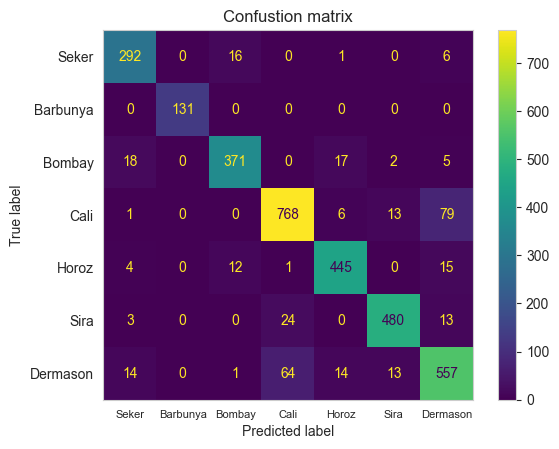

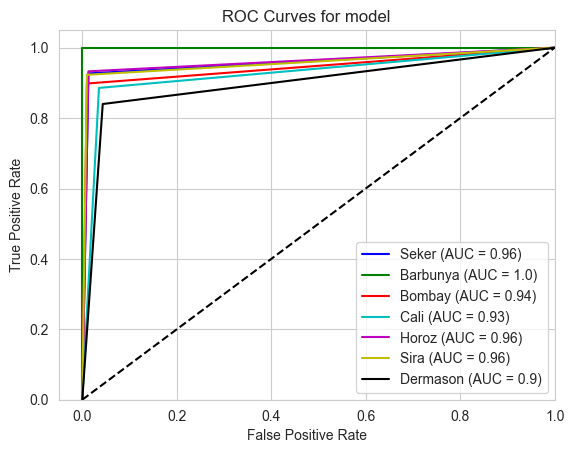

The mean AUC score for the model is 0.95


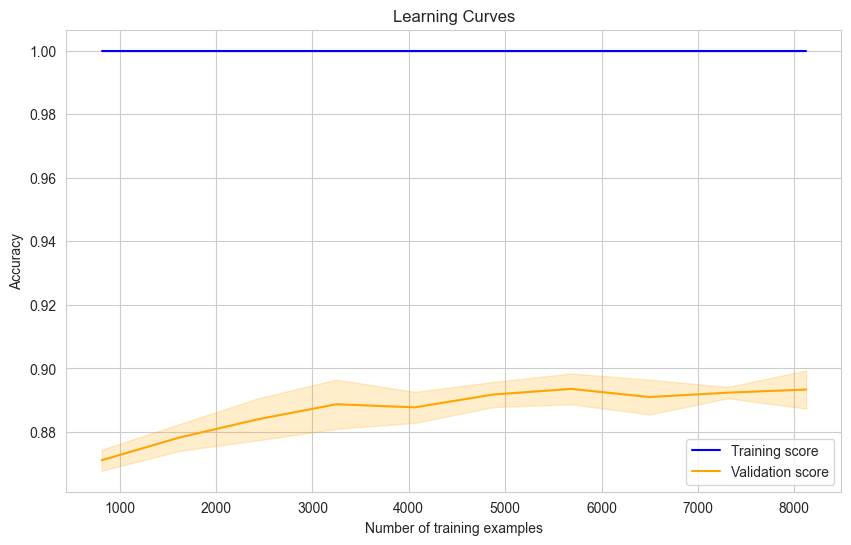

In [157]:
# Initial Decision Tree model
tree_model_1 = DecisionTreeClassifier(random_state=seed)

tree_model_1.fit(X_train, y_train)

tree_model_1_y_preds = tree_model_1.predict(X_valid)

print(f"Initial Decision Tree metrics:")
eval_model(tree_model_1)
get_learning_curves(tree_model_1)

In [158]:
# Find optimal Decision Tree parameters
tree_param_grid = [{
    'max_depth': [5, 7, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 5, 10, 15],
    'max_leaf_nodes': [None, 10],
    'max_features': [None, 'sqrt', 'log2']
}]

tree_optimal_params = GridSearchCV(
    estimator = DecisionTreeClassifier(),
    param_grid = tree_param_grid,
    cv=5,
    scoring = 'accuracy',
    n_jobs=3,
    verbose=1,
)

# tree_optimal_params.fit(X_train, y_train)
# print(f"Optimal Decision Tree parameters: {tree_optimal_params.best_params_}")

# Optimisation notes:
# Optimal Decision Tree parameters: {'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

Optimised Decision Tree metrics:
Accuracy: 0.909
Average Precision: 0.925
Average Recall: 0.921
Average F1-Score: 0.923

Class order: ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']
Support for each class: [315 131 413 867 477 520 663]
Per-class Precision: [0.901 1.    0.916 0.885 0.957 0.966 0.849]
Per-class Recall:    [0.921 1.    0.898 0.922 0.941 0.915 0.849]
Per-class F1-score:  [0.911 1.    0.907 0.903 0.949 0.94  0.849]
The AUC scores for the model are: [0.9551074310110453, 1.0, 0.943434412537698, 0.940141201379321, 0.967212287752965, 0.9547265016909119, 0.9062231180785544]


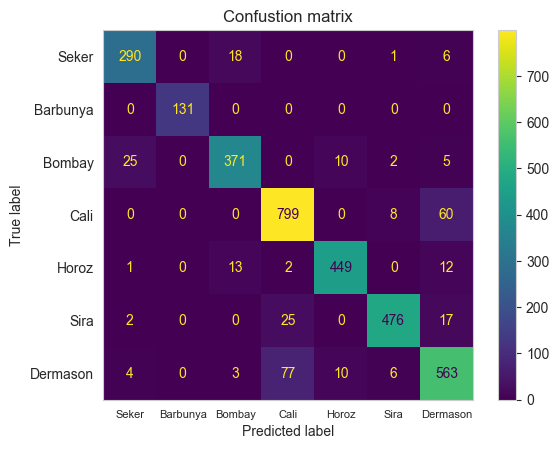

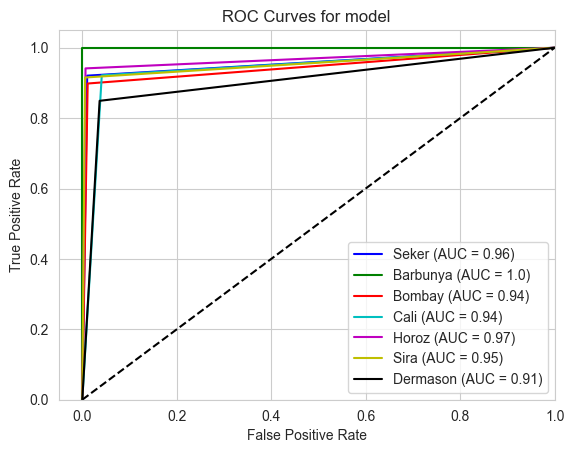

The mean AUC score for the model is 0.95


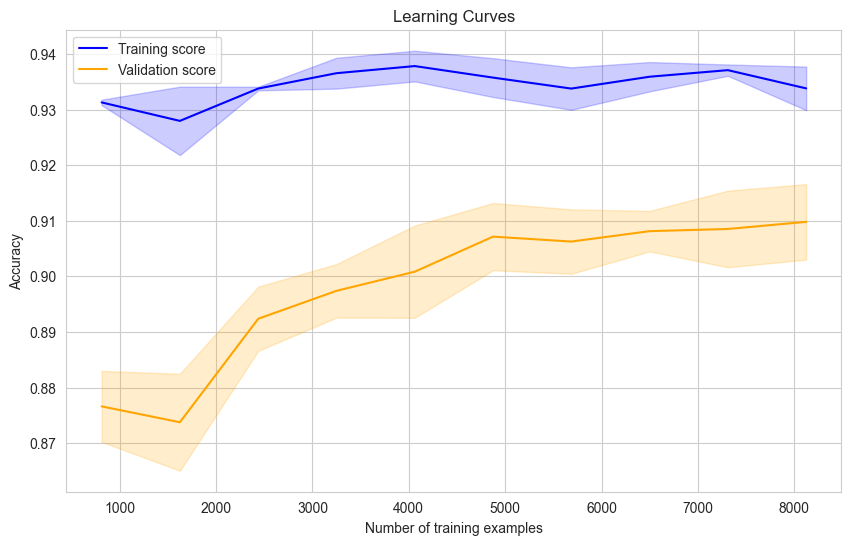

In [159]:
# Define and evaluate optimised Decision Tree

tree_model_2 = DecisionTreeClassifier(random_state=seed, max_depth=8, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2)
tree_model_2.fit(X_train, y_train)
tree_model_2_y_preds = tree_model_2.predict(X_valid)

print("Optimised Decision Tree metrics:")
eval_model(tree_model_2)
get_learning_curves(tree_model_2)

Initial Random Forest metrics:
Accuracy: 0.924
Average Precision: 0.94
Average Recall: 0.936
Average F1-Score: 0.938

Class order: ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']
Support for each class: [315 131 413 867 477 520 663]
Per-class Precision: [0.952 1.    0.948 0.898 0.956 0.957 0.869]
Per-class Recall:    [0.937 1.    0.932 0.923 0.956 0.942 0.864]
Per-class F1-score:  [0.944 1.    0.94  0.91  0.956 0.95  0.867]
The AUC scores for the model are: [0.9658117670165862, 1.0, 0.9625699088405822, 0.9432982916913351, 0.9743779335871543, 0.967315744269687, 0.9163352902956714]


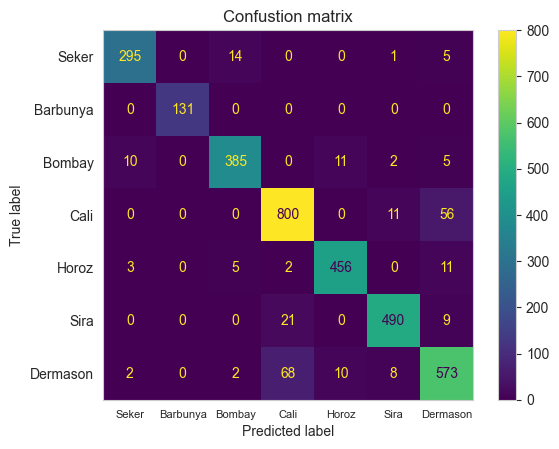

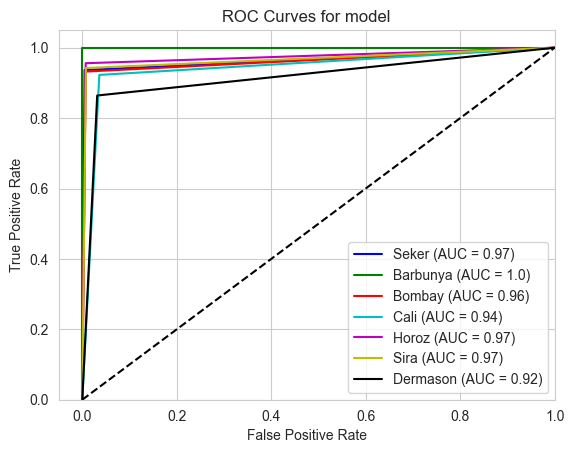

The mean AUC score for the model is 0.96


In [160]:
# Initial Random Forest model
forest_model_1 = RandomForestClassifier(random_state=seed)

forest_model_1.fit(X_train, y_train)

forest_model_1_y_preds = forest_model_1.predict(X_valid)

print(f"Initial Random Forest metrics:")
eval_model(forest_model_1)

In [161]:
# Find optimal Random Forest model hyperparameters
forest_param_grid = [{
    'n_estimators': [200, 250],
    'max_depth': [30],
    'min_samples_split': [5],
    'class_weight': ['balanced']
}]

forest_optimal_params = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = forest_param_grid,
    cv = 5,
    scoring = make_scorer(accuracy_score),
    n_jobs=3,
    verbose=1,
)

# forest_optimal_params.fit(X_train, y_train)
# print(f"Optimal Random Forest parameters: {forest_optimal_params.best_params_}")

# Finding optimal parameters notes:
# Optimal Random Forest parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
# Optimal Random Forest parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
# Optimal Random Forest parameters: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
# Optimal Random Forest parameters: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 250}

Optimised Random Forest model metrics:
Accuracy: 0.925
Average Precision: 0.94
Average Recall: 0.937
Average F1-Score: 0.939

Class order: ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']
Support for each class: [315 131 413 867 477 520 663]
Per-class Precision: [0.946 1.    0.951 0.901 0.96  0.957 0.866]
Per-class Recall:    [0.946 1.    0.932 0.919 0.952 0.94  0.87 ]
Per-class F1-score:  [0.946 1.    0.941 0.91  0.956 0.949 0.868]
The AUC scores for the model are: [0.9702480449468401, 1.0, 0.9627380891298523, 0.9421636622797076, 0.9726252582709772, 0.9663542058081486, 0.9188010185288273]


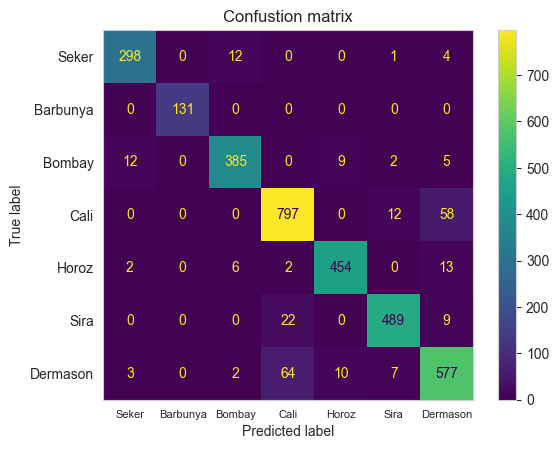

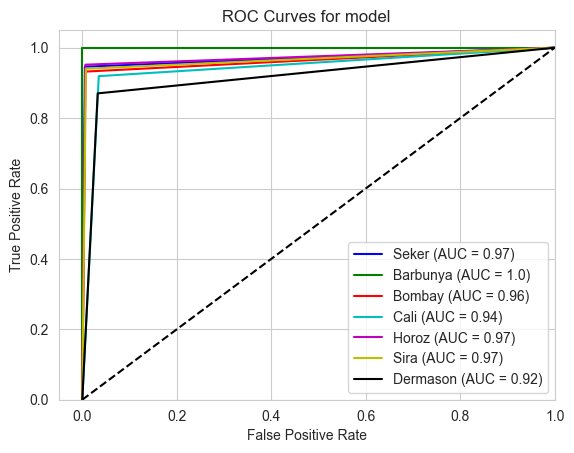

The mean AUC score for the model is 0.96


In [162]:
# Define and evaluate optimised Random Forest model
forest_model_2 = RandomForestClassifier(random_state=seed, class_weight='balanced', max_depth=30, min_samples_split=5, n_estimators=250)
forest_model_2.fit(X_train, y_train)
forest_model_2_y_preds = forest_model_2.predict(X_valid)

print("Optimised Random Forest model metrics:")
eval_model(forest_model_2)

c:\Users\lukej\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Initial XGBoost evaluation metrics:
Accuracy: 0.928
Average Precision: 0.943
Average Recall: 0.94
Average F1-Score: 0.942

Class order: ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']
Support for each class: [315 131 413 867 477 520 663]
Per-class Precision: [0.958 0.992 0.958 0.905 0.962 0.964 0.86 ]
Per-class Recall:    [0.946 1.    0.947 0.916 0.962 0.935 0.878]
Per-class F1-score:  [0.952 0.996 0.952 0.911 0.962 0.949 0.869]
The AUC scores for the model are: [0.9708992986101419, 0.9998463901689708, 0.9705065525158224, 0.9414260157978145, 0.9780382287889893, 0.964167427129744, 0.9214700315562254]


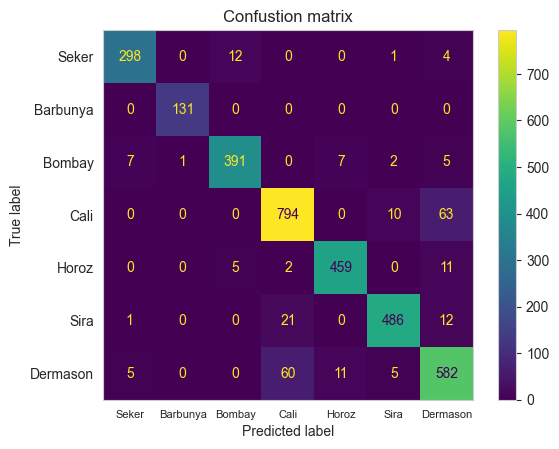

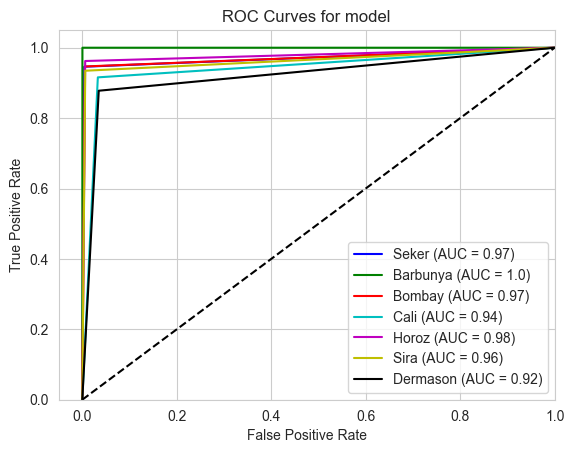

The mean AUC score for the model is 0.96


In [163]:
# Define initial XGBoost model
xg_model_1 = XGBClassifier(random_state=seed, n_jobs=3)

xg_model_1.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=False)

xg_model_1_preds = xg_model_1.predict(X_valid)

print(f"Initial XGBoost evaluation metrics:")
eval_model(xg_model_1)

In [164]:
# Find optimal XGBoost model hyperparameters
xg_param_grid = [{
    'n_estimators': [100],
    'max_depth': [30],
    'learning_rate': [0.01, 0.05, 0.1]
}]

xg_optimal_params = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = xg_param_grid,
    cv = 5,
    scoring = make_scorer(accuracy_score),
    n_jobs=3,
    verbose=1,
)

# xg_optimal_params.fit(X_train, y_train)
# print(f"Optimal XGBoost model parameters: {xg_optimal_params.best_params_}") 

# Optimisation notes:
# Optimal XGBoost model parameters: {'max_depth': 30, 'n_estimators': 100}
# Optimal XGBoost model parameters: {'learning_rate': 0.05, 'max_depth': 30, 'n_estimators': 100}

c:\Users\lukej\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Optimised XGBoost model evaluation metrics:
Accuracy: 0.928
Average Precision: 0.944
Average Recall: 0.94
Average F1-Score: 0.942

Class order: ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']
Support for each class: [315 131 413 867 477 520 663]
Per-class Precision: [0.974 0.992 0.954 0.9   0.958 0.962 0.867]
Per-class Recall:    [0.946 1.    0.949 0.919 0.956 0.935 0.876]
Per-class F1-score:  [0.96  0.996 0.951 0.909 0.957 0.948 0.872]
The AUC scores for the model are: [0.9717133656892692, 0.9998463901689708, 0.971380845690309, 0.9419651708148407, 0.9745498139584158, 0.9639929679531913, 0.9218176097807127]


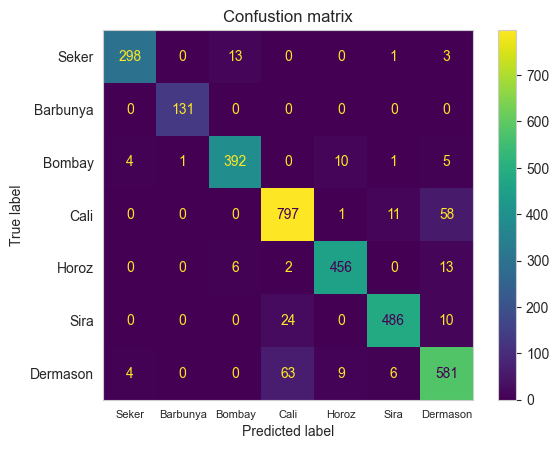

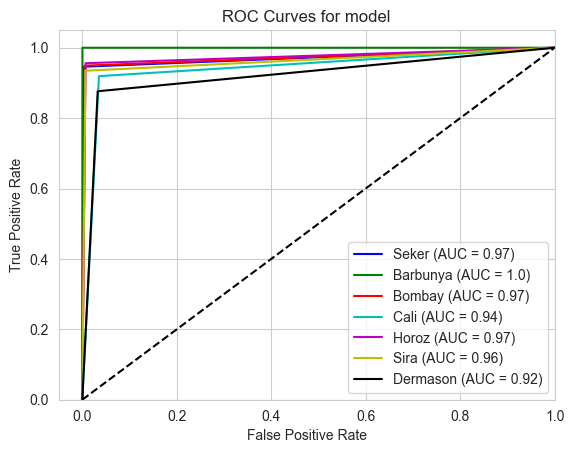

The mean AUC score for the model is 0.96


In [165]:
# Define optimised XGBoost model
xg_model_2 = XGBClassifier(random_state=seed, learning_rate=0.05, max_depth=30, n_estimators=100, n_jobs=3)

xg_model_2.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=False)

print("Optimised XGBoost model evaluation metrics:")
eval_model(xg_model_2)

Initial SVM evaluation metrics:


Accuracy: 0.929
Average Precision: 0.946
Average Recall: 0.942
Average F1-Score: 0.944

Class order: ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']
Support for each class: [315 131 413 867 477 520 663]
Per-class Precision: [0.974 1.    0.954 0.909 0.968 0.959 0.857]
Per-class Recall:    [0.937 1.    0.956 0.912 0.958 0.946 0.882]
Per-class F1-score:  [0.955 1.    0.955 0.911 0.963 0.953 0.869]
The AUC scores for the model are: [0.9669514609273646, 1.0, 0.9750128069493887, 0.9404898778510539, 0.9764574338440739, 0.9694132803693165, 0.92318161197641]


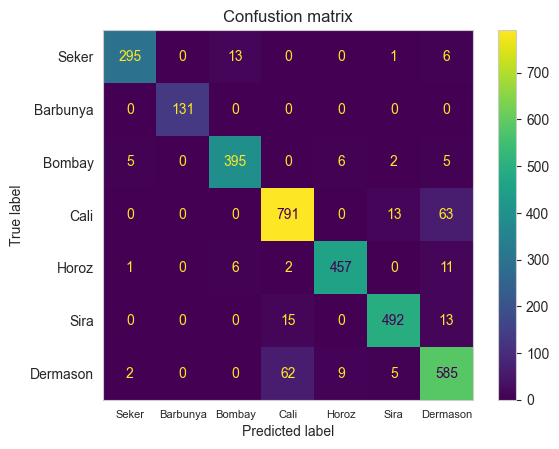

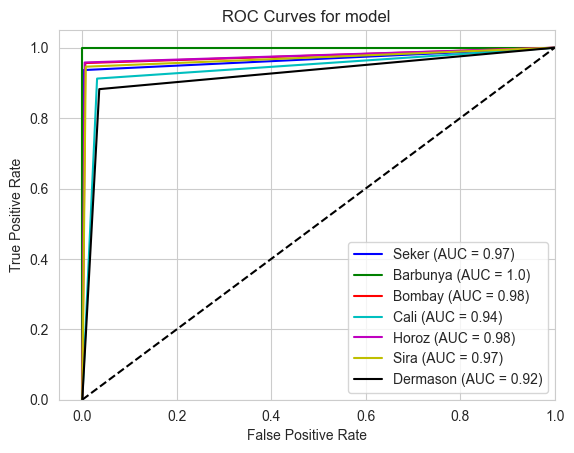

The mean AUC score for the model is 0.96


In [166]:
# Define initial SVM
svm_model_x = SVC(random_state=seed)
svm_model_x.fit(X_train, y_train)

print("Initial SVM evaluation metrics:")
eval_model(svm_model_x)

In [167]:
# SVM - Determine optimal parameters
svm_param_grid = [{
    'C': [0.1, 0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
    }]


svm_optimal_params = GridSearchCV(
    SVC(),
    svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=3,
    verbose=1,
)

# svm_optimal_params.fit(X_train, y_train)
# print("The optimal SVM parameters are: ", svm_optimal_params.best_params_)

# Optimisation notes:
# The optimal SVM parameters are:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Optimised SVM evaluation metrics:
Accuracy: 0.932
Average Precision: 0.947
Average Recall: 0.943
Average F1-Score: 0.945

Class order: ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']
Support for each class: [315 131 413 867 477 520 663]
Per-class Precision: [0.958 1.    0.956 0.906 0.964 0.974 0.87 ]
Per-class Recall:    [0.943 1.    0.944 0.926 0.954 0.952 0.881]
Per-class F1-score:  [0.95  1.    0.95  0.916 0.959 0.963 0.876]
The AUC scores for the model are: [0.9693119970228403, 1.0, 0.9691277184735257, 0.9466163272164996, 0.9740172370428504, 0.9736935691663536, 0.924447295232113]


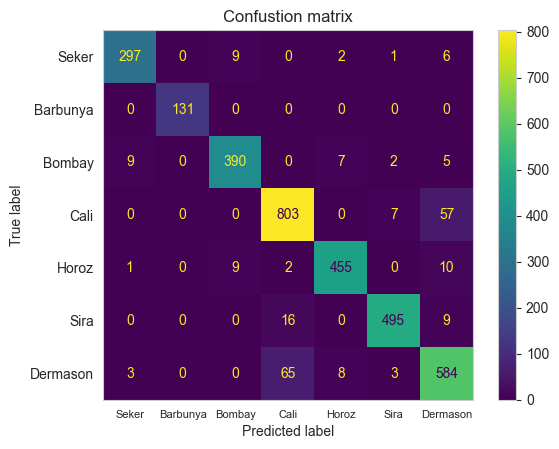

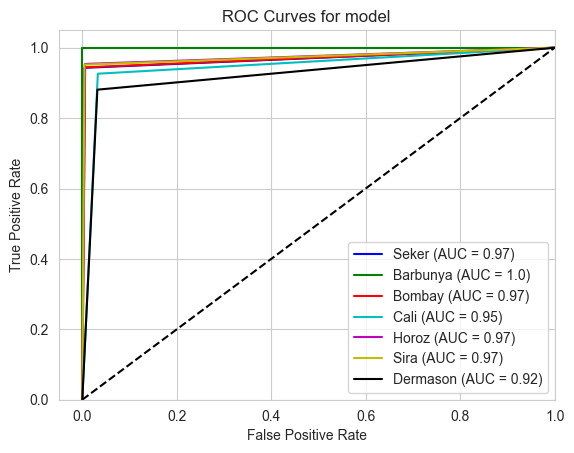

The mean AUC score for the model is 0.97


In [168]:
# Define & fit optimised SVM model; generate & evaluate predictions
svm_model = SVC(C=10, gamma=0.1, kernel='rbf', decision_function_shape='ovr', random_state=seed)

svm_model.fit(X_train, y_train)

svm_preds = svm_model.predict(X_valid)

print(f"Optimised SVM evaluation metrics:")
eval_model(svm_model)

In [169]:
# Define neural network
input_shape = [X_train.shape[1]]
output_shape = y.unique().shape[0]
print(f"Input shape is: {input_shape}")
print(f"Output shape is: {output_shape}")

neural_model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=0.3),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=output_shape, activation='softmax'),
])

Input shape is: [16]
Output shape is: 7


c:\Users\lukej\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [170]:
# Define compiler & early stopping for neural network
neural_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True,
)

In [171]:
# Fit neural network
fitted_neural_model = neural_model.fit(
    X_train, dummy_y_train,
    validation_data = (X_valid, dummy_y_valid),
    batch_size = 256,
    epochs = 40,
    verbose = 1,
    callbacks = [early_stopping],
)

Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.7702 - loss: 0.6438 - val_accuracy: 0.9084 - val_loss: 0.5445
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8986 - loss: 0.2631 - val_accuracy: 0.8839 - val_loss: 0.5081
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9127 - loss: 0.2443 - val_accuracy: 0.8098 - val_loss: 0.5237
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9131 - loss: 0.2385 - val_accuracy: 0.8925 - val_loss: 0.3780
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9062 - loss: 0.2520 - val_accuracy: 0.8656 - val_loss: 0.3801
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9093 - loss: 0.2521 - val_accuracy: 0.8470 - val_loss: 0.4064
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9138 - loss: 0.2415 - val_accuracy: 0.8898 - val_loss: 0.2938
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9154 - loss: 0.2198 - val_accuracy: 0.9111 - 

106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Accuracy: 0.932
Average Precision: 0.944
Average Recall: 0.945
Average F1-Score: 0.944

Class order: ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']
Support for each class: [315 131 413 867 477 520 663]
Per-class Precision: [0.935 0.985 0.97  0.924 0.968 0.956 0.867]
Per-class Recall:    [0.965 1.    0.925 0.909 0.964 0.962 0.893]
Per-class F1-score:  [0.95  0.992 0.947 0.916 0.966 0.959 0.88 ]
The AUC scores for the model are: [0.9791206008073479, 0.9996927803379416, 0.9604515701849331, 0.9415386545529638, 0.9796020879321242, 0.976756669708519, 0.9297459937109113]


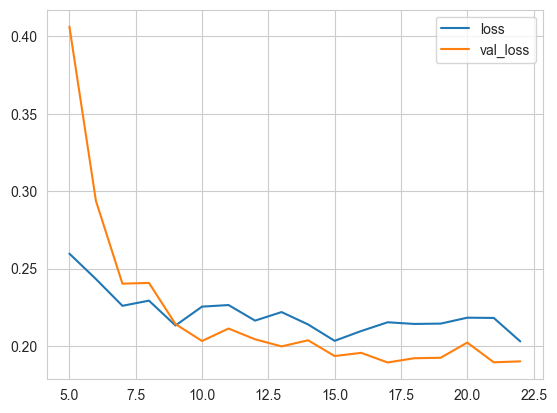

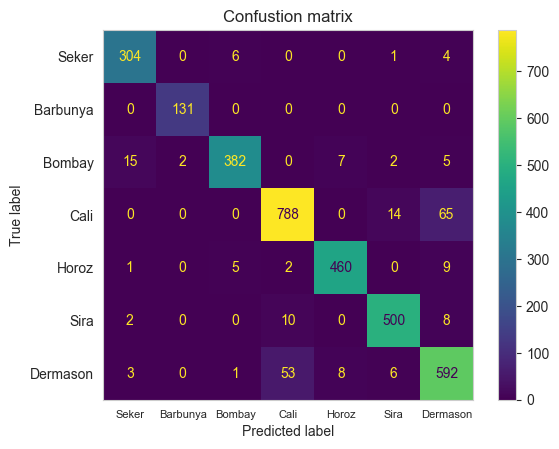

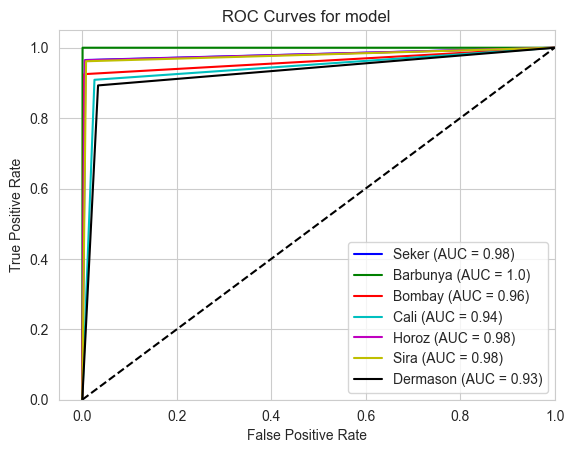

The mean AUC score for the model is 0.97


In [172]:
# Plot learning curves for neural network & produce evaluation metrics
df_nn_history = pd.DataFrame(fitted_neural_model.history)
df_nn_history.loc[5:, ['loss', 'val_loss']].plot()

eval_model(neural_model)

In [173]:
neural_model_y_preds = np.argmax(pd.DataFrame(neural_model.predict(X_valid)), axis=1)
neural_model.summary()

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_20          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,413,207 (9.21 MB)

 Trainable params: 803,367 (3.06 MB)

 Non-trainable params: 3,104 (12.12 KB)

 Optimizer params: 1,606,736 (6.13 MB)

In [174]:
neural_model.evaluate(X_valid, dummy_y_valid)

106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9366 - loss: 0.1766


[0.18934904038906097, 0.9323685765266418]

In [175]:
# Feature engineering example
def get_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name='MI scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [176]:
mi_scores = get_mi_scores(X, y)
mi_scores

perimeter              1.055792
convex_area            1.036933
equivalent_diameter    1.035189
area                   1.035129
major_axis_length      0.993432
shape_factor_2         0.953577
shape_factor_1         0.929685
minor_axis_length      0.927600
compactness            0.830727
shape_factor_3         0.830714
eccentricity           0.814752
aspect_ratio           0.814728
roundness              0.795885
shape_factor_4         0.363811
solidity               0.230919
extent                 0.197433
Name: MI scores, dtype: float64

In [177]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information scores')

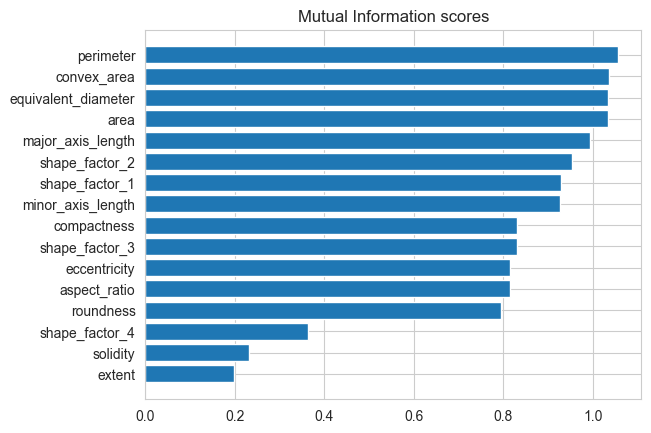

In [178]:
plt.figure()
plot_mi_scores(mi_scores)

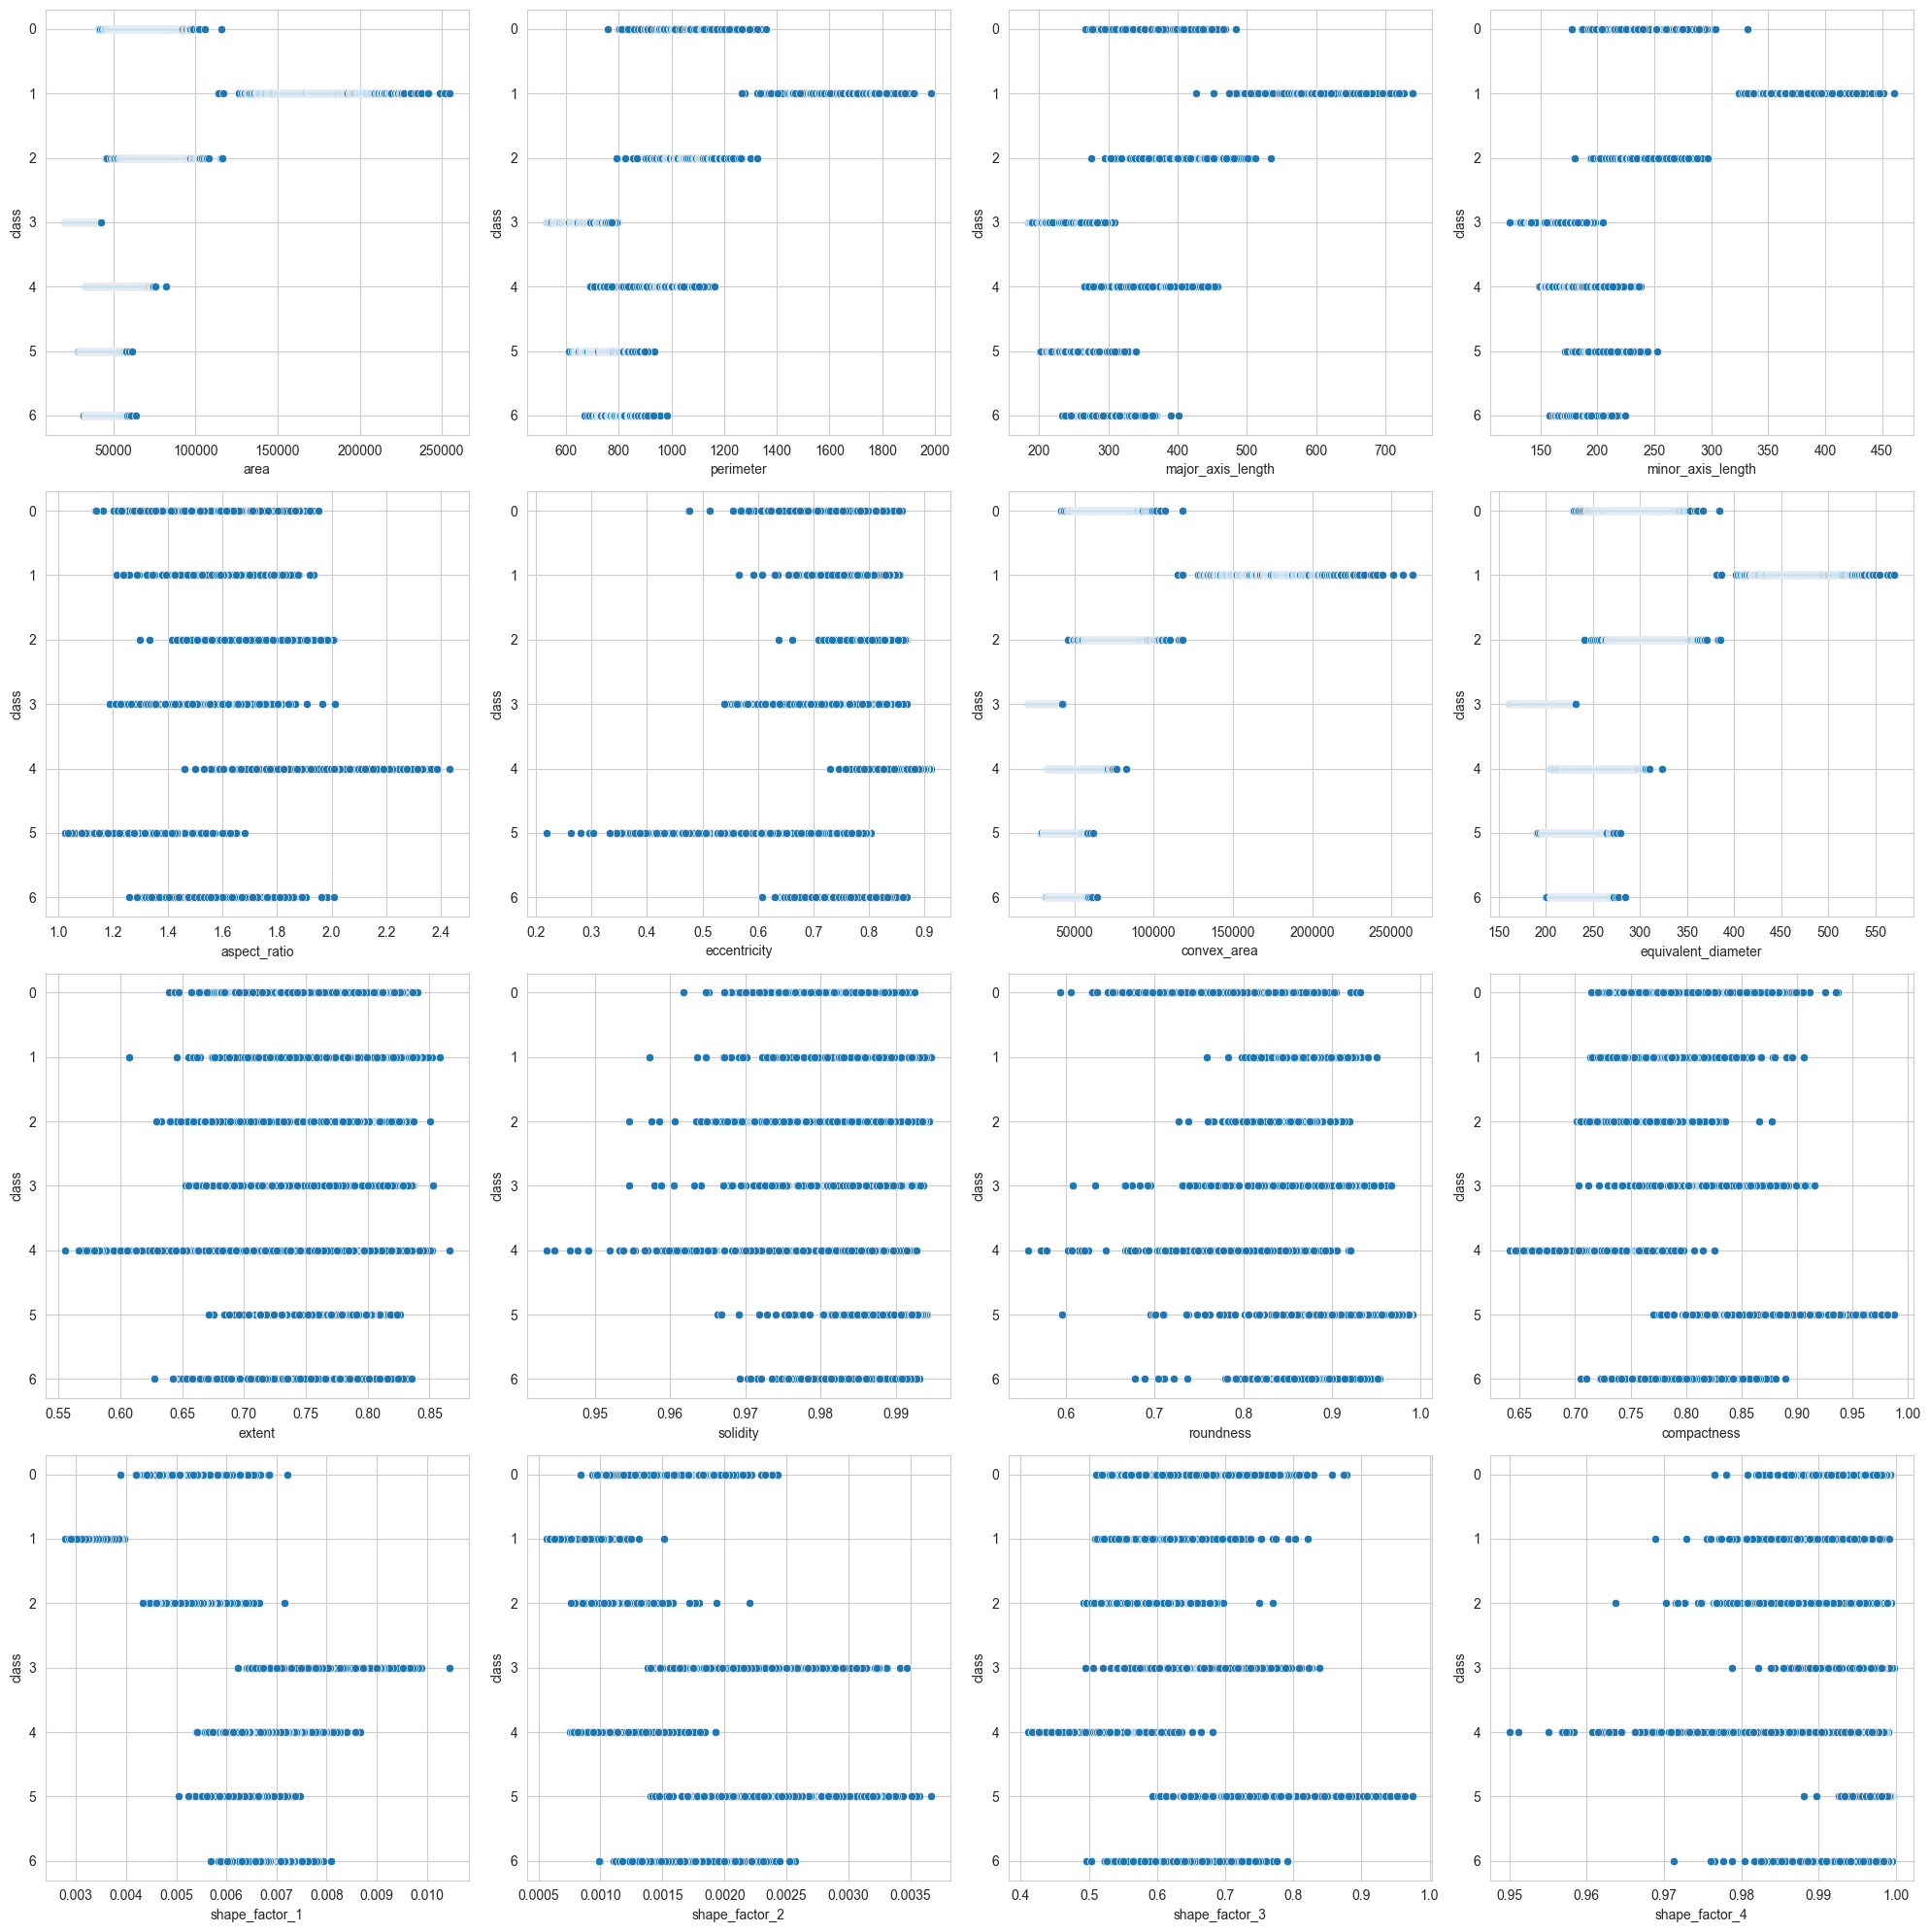

In [179]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for variable, subplot in zip(feature_names, ax.flatten()):
    sns.scatterplot(x=X[variable], y=y, ax=subplot)
plt.tight_layout()

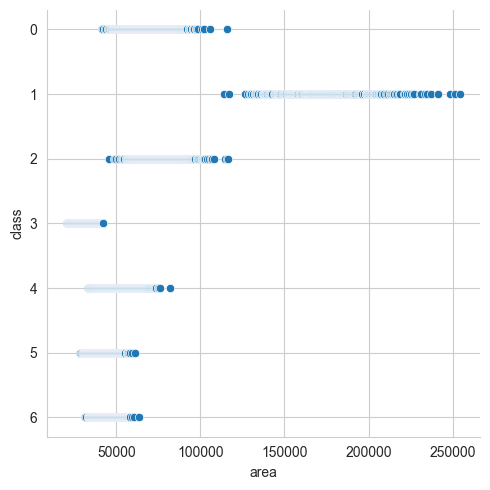

In [180]:
sns.relplot(x=X['area'], y=y)

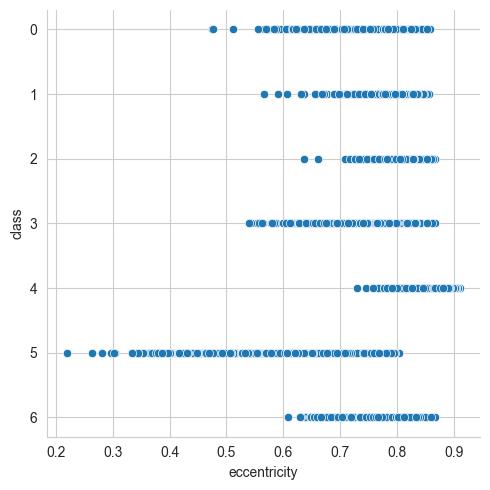

In [181]:
sns.relplot(x=X['eccentricity'], y=y)

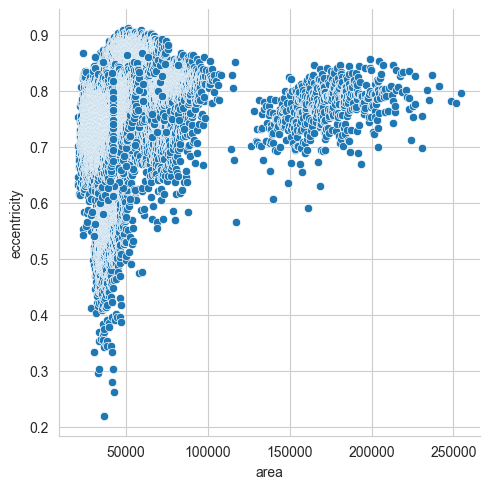

In [182]:
sns.relplot(x=X['area'], y=X['eccentricity'])

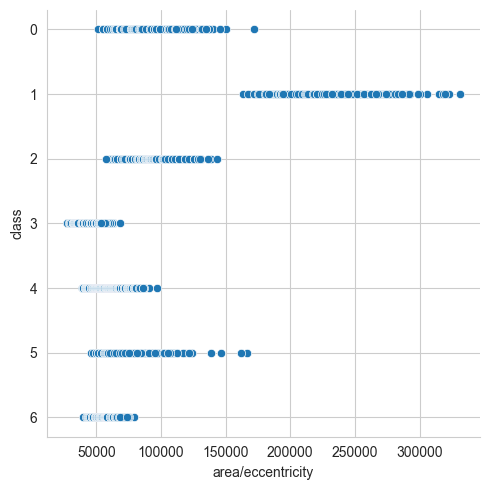

In [183]:
X['area/eccentricity'] = X['area'] / X['eccentricity']
sns.relplot(x=X['area/eccentricity'], y=y)

Input shape is: [17]
Output shape is: 7


c:\Users\lukej\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.7536 - loss: 0.7093 - val_accuracy: 0.0387 - val_loss: 11.1305
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8996 - loss: 0.2845 - val_accuracy: 0.0800 - val_loss: 3.7102
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9019 - loss: 0.2654 - val_accuracy: 0.2118 - val_loss: 2.5741
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9043 - loss: 0.2569 - val_accuracy: 0.3086 - val_loss: 1.9392
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9124 - loss: 0.2536 - val_accuracy: 0.5322 - val_loss: 1.2853
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9021 - loss: 0.2688 - val_accuracy: 0.5470 - val_loss: 1.0913
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9034 - loss: 0.2672 - val_accuracy: 0.6344 - val_loss: 0.9876
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9132 - loss: 0.2409 - val_accuracy: 0.7197 -

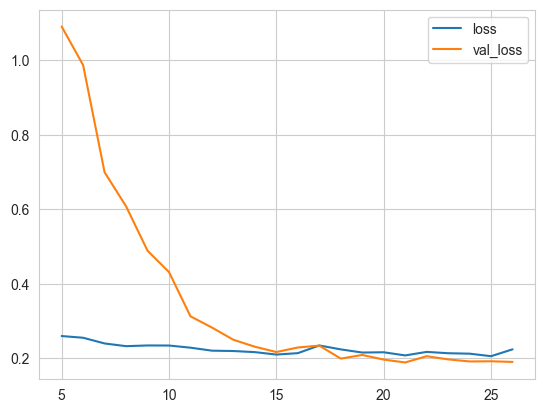

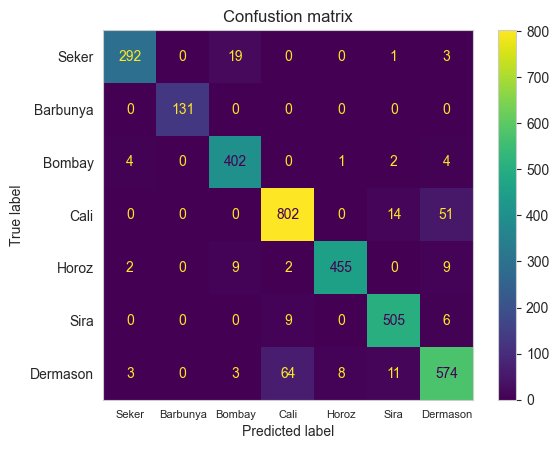

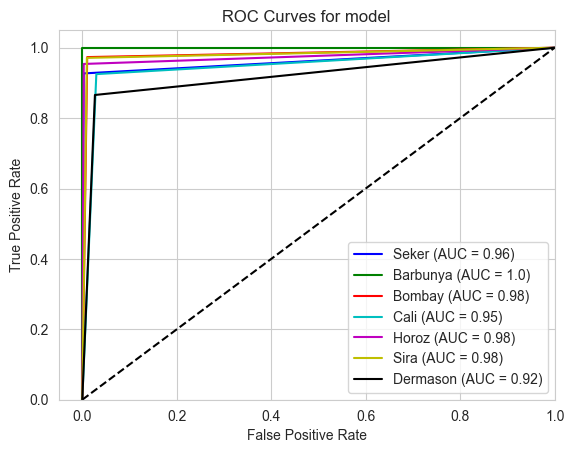

The mean AUC score for the model is 0.97


In [184]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=seed)

# Define neural network
input_shape = [X_train.shape[1]]
output_shape = y.unique().shape[0]
print(f"Input shape is: {input_shape}")
print(f"Output shape is: {output_shape}")

neural_model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=0.3),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=output_shape, activation='softmax'),
])

# Define compiler & early stopping for neural network
neural_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True,
)

fitted_neural_model = neural_model.fit(
    X_train, dummy_y_train,
    validation_data = (X_valid, dummy_y_valid),
    batch_size = 256,
    epochs = 40,
    verbose = 1,
    callbacks = [early_stopping],
)
    
# Plot learning curves for neural network & produce evaluation metrics
df_nn_history = pd.DataFrame(fitted_neural_model.history)
df_nn_history.loc[5:, ['loss', 'val_loss']].plot()

eval_model(neural_model)

In [185]:
# Example PCA
def plot_variance(pca, width=8):
    fig, ax = plt.subplots(1,2)
    n = pca.n_components_
    grid = np.arange(1, n+1)
    evr = pca.explained_variance_ratio_
    ax[0].bar(grid, evr)
    ax[0].set(xlabel='Component', title="% Variance Explained", ylim=(0.0, 1.0))
    cv = np.cumsum(evr)
    ax[1].plot(np.r_[0, grid], np.r_[0, cv], 'o-')
    ax[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
    fig.set(figwidth=8)
    return ax


In [186]:
high_mi_features = ['perimeter', 'equivalent_diameter', 'convex_area', 'area']
X = X.loc[:, high_mi_features]

pca = PCA()
X_pca = pca.fit_transform(X)
component_names = [f"PC{i+1}" for i in range (X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_pca.head()

,PC1,PC2,PC3,PC4
0,-35153.628239,20.164501,-70.236707,-1.346863
1,-34590.019338,-60.822153,-52.496421,-4.740642
2,-33767.738549,37.141301,-61.680651,-1.406119
3,-32590.275453,-241.307268,-69.766748,-1.466494
4,-32716.509633,69.162641,-67.829906,0.954965


In [187]:
loadings = pd.DataFrame(pca.components_.T,
columns=component_names,
index=X.columns)
loadings

,PC1,PC2,PC3,PC4
perimeter,0.004959,-0.085663,0.980547,-0.176534
equivalent_diameter,0.001395,-0.006828,0.176598,0.984258
convex_area,0.712472,-0.698785,-0.063649,0.005563
area,0.701681,0.710151,0.057347,-0.006357


array([<Axes: title={'center': '% Variance Explained'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

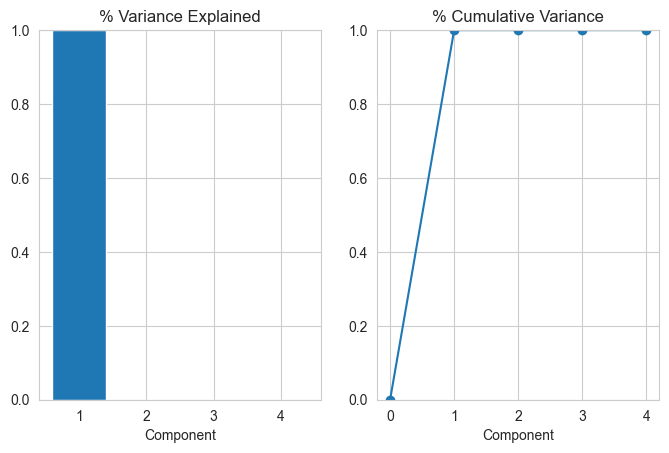

In [188]:
plot_variance(pca)

In [189]:
idx = X_pca['PC2'].sort_values(ascending=False).index
cols = ['convex_area', 'area']

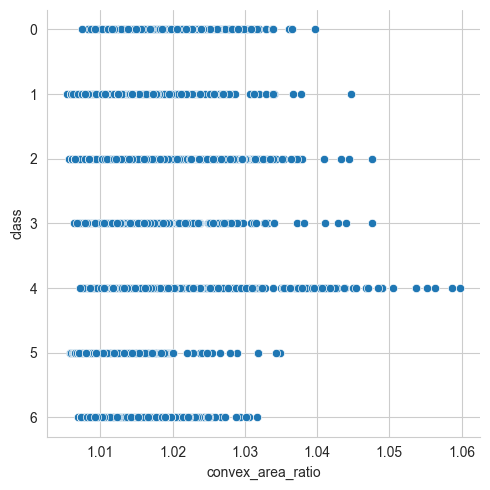

In [190]:
X['convex_area_ratio'] = X['convex_area'] / X['area']
sns.relplot(x=X['convex_area_ratio'], y=y)